# HEASARC Pre-curated Suzaku Light Curve data set

This notebook provides a demonstration of how to work with pre-curated HEASARC data sets. We conduct a basic exploratory data analysis and unsupervised machine learning.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.time import TimeDelta
import lightkurve as lk

change to your path containing HEASARC pre-curated data

In [4]:
path='/efs/STG_Tutorial_Data/Astro_CNN/'
#path='/Users/bppowel1/Powell_STG_Data/'
weightpath='./model_weights/'

Open pre-curated HEASARC data containing all Suzaku light curves

In [5]:
fp=open(path+'suzaku_lcs_p5_2.pkl','rb');lcs_soft=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lcs_2_10.pkl','rb');lcs_hard=pickle.load(fp);fp.close()
fp=open(path+'suzaku_times_p5_2.pkl','rb');times=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_tgtlabels.pkl','rb');tgtlabels=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_tstarts.pkl','rb');tstarts=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_ra.pkl','rb');ra=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_dec.pkl','rb');dec=pickle.load(fp);fp.close()

In order to group observations of the same target, find unique target names. Note that this is not a perfect method as the same target may be named with slight differences in different observations.  For a slightly more complete solution (though more difficult to work with the names, so we will avoid it here) keep only alphanumeric characters and change letters to lowercase with this command:
tgtlabels=np.array([''.join([i for i in t if i.isalpha() or i.isnumeric()]).lower() for t in tgtlabels])

In [6]:
tgtlabels=np.array(tgtlabels)
tgtlabels_unique=np.unique(tgtlabels).tolist()

All loaded data files are in list format.  Change to numpy arrays for more functionality.

In [7]:
lcs_hard=np.array(lcs_hard)
lcs_soft=np.array(lcs_soft)
times=np.array(times)
tstarts=np.array(tstarts)
ra=np.array(ra)
dec=np.array(dec)

/tmp/ipykernel_1730/4089444729.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lcs_hard=np.array(lcs_hard)
/tmp/ipykernel_1730/4089444729.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lcs_soft=np.array(lcs_soft)
/tmp/ipykernel_1730/4089444729.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  times=np.array(times)


Time to move on to some machine learning.  For any type of machine learning analysis, the data must be the same shape.  Turn all the pre-curated light curves into length 64 (arbitrary choice, pick whatever suits your analysis).

In [8]:
lenmask=[True if len(lc)>64 else False for lc in lcs_hard]
lcs_hard_64=np.array(lcs_hard)[lenmask].tolist()
lcs_hard_64=np.array([lc[:64] for lc in lcs_hard_64])
lcs_soft_64=np.array(lcs_soft)[lenmask].tolist()
lcs_soft_64=np.array([lc[:64] for lc in lcs_soft_64])
times_64=np.array(times)[lenmask].tolist()
times_64=np.array([lc[:64] for lc in times_64])
tgtlabels_64=np.array(tgtlabels)[lenmask].tolist()
tgtlabels_64=np.array([lc[:64] for lc in tgtlabels_64])

In [9]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2,random_state=1234)
hpca=pca.fit_transform(lcs_hard_64)
pca=PCA(n_components=2,random_state=1234)
spca=pca.fit_transform(lcs_soft_64)

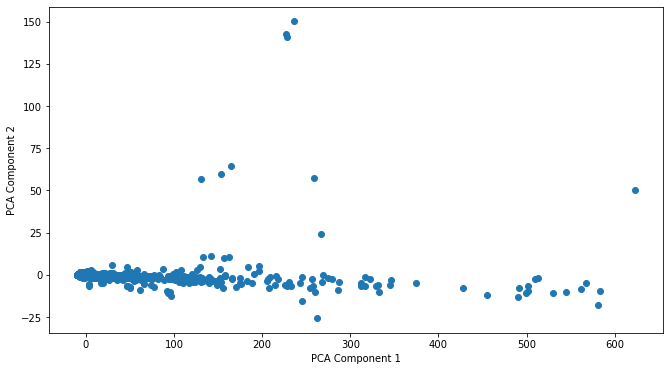

In [10]:
plt.figure(figsize=(11,6))
plt.scatter(hpca[:,0],hpca[:,1])
#for i, txt in enumerate(tgtlabels_64.tolist()):
#    plt.annotate(txt, (hpca[i,0], hpca[i,1]))
plt.xlabel('PCA Component 1');
plt.ylabel('PCA Component 2');

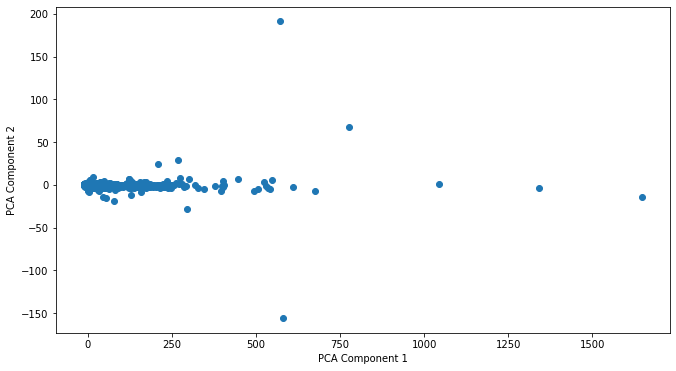

In [11]:
plt.figure(figsize=(11,6))
plt.scatter(spca[:,0],spca[:,1])
#for i, txt in enumerate(tgtlabels_64.tolist()):
#    plt.annotate(txt, (hpca[i,0], hpca[i,1]))
plt.xlabel('PCA Component 1');
plt.ylabel('PCA Component 2');

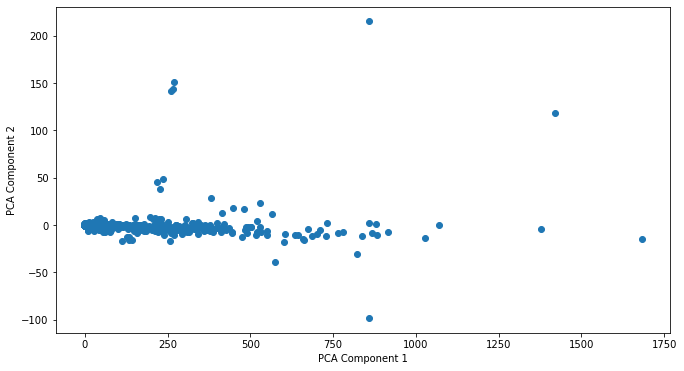

In [12]:
ds0=spca[:,0]-np.median(spca[:,0])
dh0=hpca[:,0]-np.median(hpca[:,0])
ds1=spca[:,1]-np.median(spca[:,1])
dh1=hpca[:,1]-np.median(hpca[:,1])
d0=ds0+dh0
d1=ds1+dh1
plt.figure(figsize=(11,6))
plt.scatter(d0,d1)
plt.xlabel('PCA Component 1');
plt.ylabel('PCA Component 2');

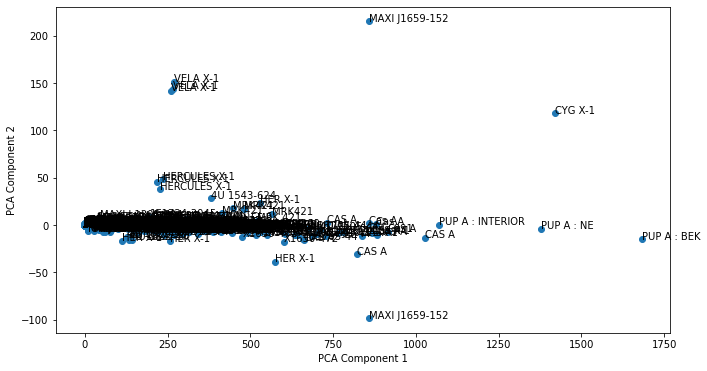

In [13]:
plt.figure(figsize=(11,6))
plt.scatter(d0,d1)
for i, txt in enumerate(tgtlabels_64.tolist()):
    plt.annotate(txt, (d0[i], d1[i]))
plt.xlabel('PCA Component 1');
plt.ylabel('PCA Component 2');

PCA preserves global distance from the higher dimensional data, so it's a great tool to identify outliers, but not necessarily relationships between the outliers.  We've already looked at Her X-1 and Cyg X-1, so we can see that PCA also identifies Vela X-1 and MAXI J1659-152 as "odd", so let's take a look.

In [14]:
lcs_hard_joined=[lcs_hard[tgtlabels==t] for t in tgtlabels_unique]
lcs_soft_joined=[lcs_soft[tgtlabels==t] for t in tgtlabels_unique]
times_joined=[times[tgtlabels==t] for t in tgtlabels_unique]
tstarts_joined=[tstarts[tgtlabels==t] for t in tgtlabels_unique]
ra_joined=[ra[tgtlabels==t] for t in tgtlabels_unique]
dec_joined=[dec[tgtlabels==t] for t in tgtlabels_unique]

joined_means=[]
joined_variances=[]
for i in range(len(lcs_hard_joined)):
    joined_means.append(np.hstack((lcs_hard_joined[i])).mean())
    joined_variances.append(np.hstack((lcs_hard_joined[i])).var())
    
df_joined=pd.DataFrame(joined_means,columns=['means'])
df_joined['variances']=joined_variances
df_joined['tgt']=tgtlabels_unique
df_joined=df_joined.dropna()

t_suzaku_start=Time('2000-01-01')
def timeconvert(idx,hs='hard'):
    tpart=times_joined[idx]
    if hs=='soft':
        fpart=lcs_soft_joined[idx]
    elif hs=='hard':
        fpart=lcs_hard_joined[idx]
    elif hs=='ratio':
        fpart=lcs_hard_joined[idx]/lcs_soft_joined[idx]
    tspart=tstarts_joined[idx]
    tjpart=[]
    for t,ts in zip(tpart,tspart):
        td=TimeDelta(t,format='sec')+t_suzaku_start+TimeDelta(ts,format='sec')
        for d in td:
            tjpart.append(d.isot)
    fjpart=np.hstack(fpart)
    return tjpart,fjpart

/tmp/ipykernel_1730/59617983.py:11: RuntimeWarning: Mean of empty slice.
  joined_means.append(np.hstack((lcs_hard_joined[i])).mean())
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1730/59617983.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  joined_variances.append(np.hstack((lcs_hard_joined[i])).var())
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


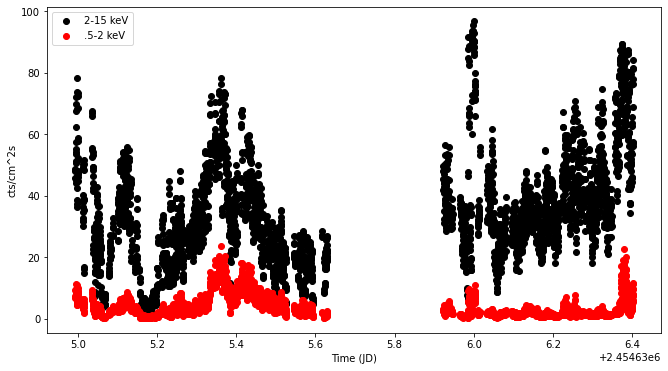

In [15]:
idx=tgtlabels_unique.index('VELA X-1')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

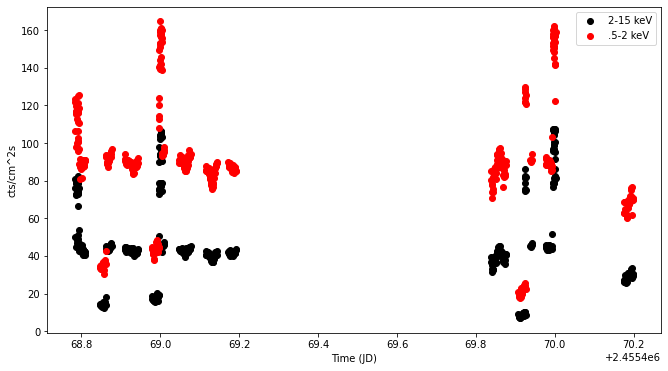

In [16]:
idx=tgtlabels_unique.index('MAXI J1659-152')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

Indeed, these light curves are quite interesting.  Another method of dimensionality reduction is TSNE.  Try it.

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


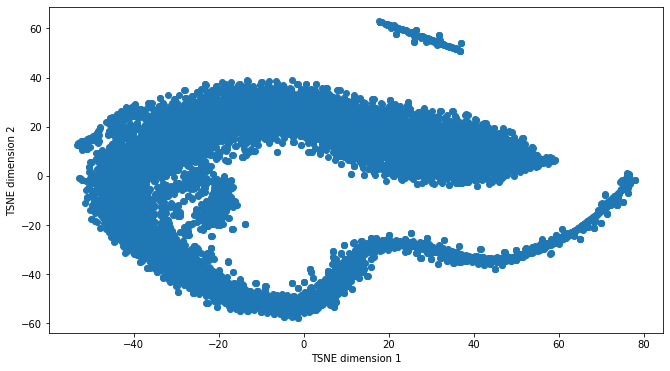

In [17]:
from sklearn.manifold import TSNE
############################
####### CHANGE THESE #######
perplexity=30.
early_exaggeration=12.
learning_rate=200.
############################
############################
tsne=TSNE(n_components=2,perplexity=perplexity,early_exaggeration=early_exaggeration,learning_rate=learning_rate,random_state=1234)
htsne=tsne.fit_transform(lcs_hard_64)
plt.figure(figsize=(11,6));
plt.scatter(htsne[:,0],htsne[:,1]);
plt.xlabel('TSNE dimension 1');
plt.ylabel('TSNE dimension 2');

TSNE is a heuristic that attempts to preserve local distance in the higher dimension rather than global.  The dimensions are arbitrary and meaning can only extracted from proximity.  So, let's look at the outlier group.

In [ ]:
!pip install umap-learn

2022-07-11 17:49:12.748411: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-11 17:49:12.753305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 17:49:12.753328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


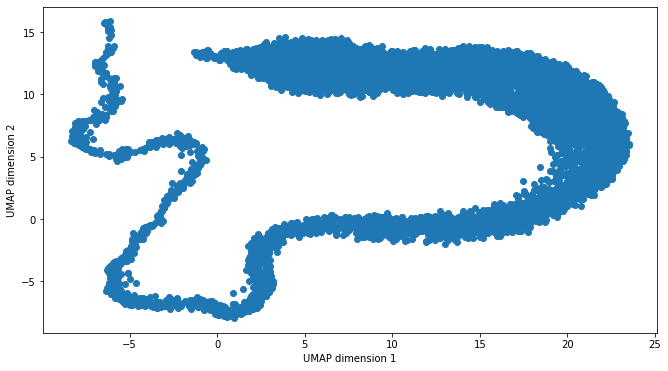

In [18]:
from umap import UMAP
############################
####### CHANGE THESE #######
n_neighbors=20
min_dist=1.
############################
############################
um=UMAP(n_components=2,n_neighbors=n_neighbors,min_dist=min_dist)
humap=um.fit_transform(lcs_hard_64)
plt.figure(figsize=(11,6));
plt.scatter(humap[:,0],humap[:,1]);
plt.xlabel('UMAP dimension 1');
plt.ylabel('UMAP dimension 2');

We can generally see hard X-ray emission is greater than soft X-ray emission.  That may be the only thing PCA is capable of here.  what can we do to find more intelligent represenations?  If we want to analyze the behavior of the sources, neglecting the magnitude, we need to scale the data.   The scikit-learn library offers a variety of options on this front.  Here, use the standard scaler, creating nicely Gaussian light curves.

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


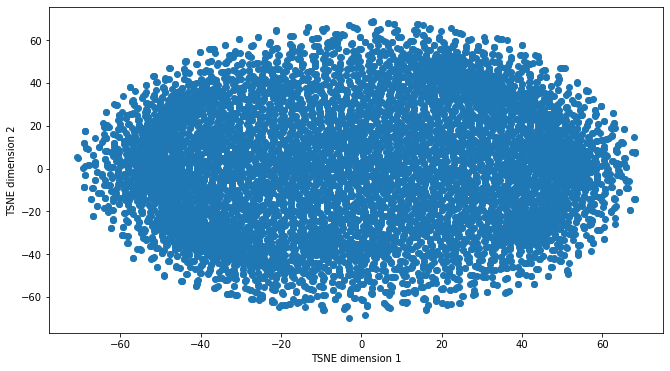

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

###########################
####### PICK ONE ##########
###########################
scaler=StandardScaler()
#scaler=MinMaxScaler()
#scaler=QuantileTransformer(n_quantiles=64)
###########################

lcs_hard_64_scaled=[]
for i in range(lcs_hard_64.shape[0]):
    s=scaler
    lcs_hard_64_scaled.append(s.fit_transform(lcs_hard_64[i].reshape(-1,1)).T[0])
lcs_soft_64_scaled=[]
for i in range(lcs_soft_64.shape[0]):
    s=scaler
    lcs_soft_64_scaled.append(s.fit_transform(lcs_soft_64[i].reshape(-1,1)).T[0])
lcs_hard_64_scaled=np.array(lcs_hard_64_scaled)
lcs_soft_64_scaled=np.array(lcs_soft_64_scaled)

############
### PLOT ###
############

tsne=TSNE(n_components=2,random_state=1234)
htsne=tsne.fit_transform(lcs_hard_64_scaled)
plt.figure(figsize=(11,6));
plt.scatter(htsne[:,0],htsne[:,1]);
plt.xlabel('TSNE dimension 1');
plt.ylabel('TSNE dimension 2');

Well, that went as expected.  A bunch of Gaussian light curves will create a Gaussian space.  We have very little to learn from this representation.  However, what happens if we learn a more intelligent representation through an autoencoder neural network?  Although light curves are a temporal process, here let's ignore that and allow the autoencoder to analyze the numerical replationships without the complexity of time.  We are just exploring after all.

In [20]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *

In [21]:
# PICK ONE
activation_function='relu'
#activation_function='tanh'
#activation_function='sigmoid'

# PICK ONE
optimizer='rmsprop'
#optimizer='adam'
#optimizer='adadelta'
#optimizer='nadam'
#omtimizer='adagrad'
#optimizer='sgd'

inputlayer=Input(64,)
x=Dense(64,activation=activation_function)(inputlayer)
x=Dense(32,activation=activation_function)(x)
x=Dense(16,activation=activation_function)(x)
encoded=Dense(8,activation=activation_function)(x)
x=Dense(16,activation=activation_function)(encoded)
x=Dense(32,activation=activation_function)(x)
outputlayer=Dense(64,activation='linear')(x)
model=Model(inputs=[inputlayer],outputs=[outputlayer])
encoder=Model(inputs=[inputlayer],outputs=[encoded])
model.compile(loss='mse',optimizer=optimizer)
modelcheckpoint=ModelCheckpoint(weightpath+'suzaku_hard_lc.weights', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlystopping=EarlyStopping(monitor='loss', min_delta=0., patience=20, verbose=0, mode='auto')
model.fit(lcs_hard_64_scaled,lcs_hard_64_scaled,epochs=1000,callbacks=[modelcheckpoint,earlystopping]);
model.load_weights(weightpath+'suzaku_hard_lc.weights')

2022-07-11 17:50:23.875948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 17:50:23.876633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 17:50:23.876726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-11 17:50:23.876790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-11 17:50:23.876852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/1000
244/262 [==========================>...] - ETA: 0s - loss: 0.9352
Epoch 1: loss improved from inf to 0.92996, saving model to ./model_weights/suzaku_hard_lc.weights
262/262 [==============================] - 1s 2ms/step - loss: 0.9300
Epoch 2/1000
251/262 [===========================>..] - ETA: 0s - loss: 0.8372
Epoch 2: loss improved from 0.92996 to 0.83685, saving model to ./model_weights/suzaku_hard_lc.weights
262/262 [==============================] - 0s 1ms/step - loss: 0.8369
Epoch 3/1000
251/262 [===========================>..] - ETA: 0s - loss: 0.8133
Epoch 3: loss improved from 0.83685 to 0.81296, saving model to ./model_weights/suzaku_hard_lc.weights
262/262 [==============================] - 0s 1ms/step - loss: 0.8130
Epoch 4/1000
251/262 [===========================>..] - ETA: 0s - loss: 0.8014
Epoch 4: loss improved from 0.81296 to 0.80109, saving model to ./model_weights/suzaku_hard_lc.weights
262/262 [==============================] - 0s 1ms/step - loss: 0.8

262/262 [==============================] - 0s 841us/step


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


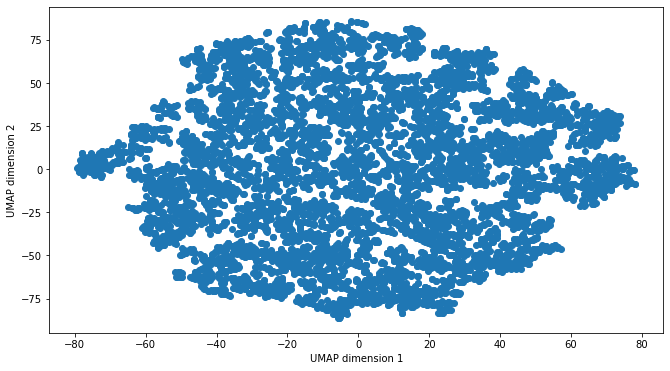

In [22]:
#PLOT
tsne=TSNE(n_components=2,random_state=1234)

ehstsne=tsne.fit_transform(encoder.predict(lcs_hard_64_scaled))
plt.figure(figsize=(11,6));
plt.scatter(ehstsne[:,0],ehstsne[:,1]);
plt.xlabel('UMAP dimension 1');
plt.ylabel('UMAP dimension 2');

Beautiful! A simple encoding turned an unintelligible blob into very distinct groupings!  Cluster them using the DBSCAN method.

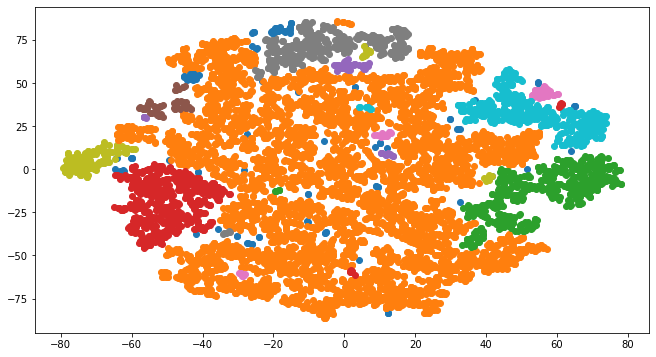

In [23]:
from sklearn.cluster import DBSCAN

############
## CHANGE ##
eps=2.5
############

dbs=DBSCAN(eps=eps)
labels=dbs.fit_predict(ehstsne)
plt.figure(figsize=(11,6))
for i in range(-1,labels.max()):
    plt.scatter(ehstsne[labels==i,0],ehstsne[labels==i,1])

Now let's look at one of these groups to see if it acutally makes sense.  Your run of the neural net will be different, so the groupings will not be consistent.  One of my groups contained 'A1750S','ABELL 426 NNE7','EK TRA', and 'E0102.2-7219'.  Analyzing this group below.

Plot the light curves

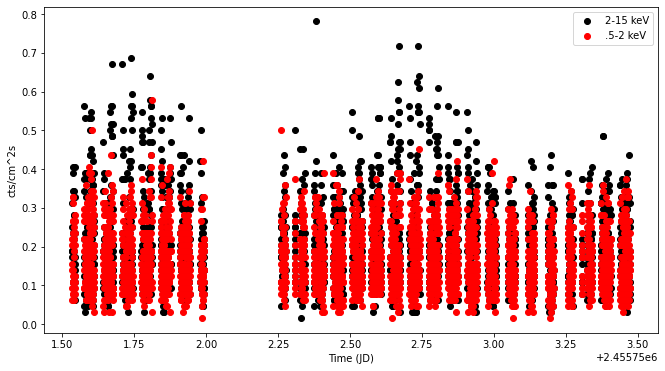

In [24]:
idx=tgtlabels_unique.index('A1750S')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

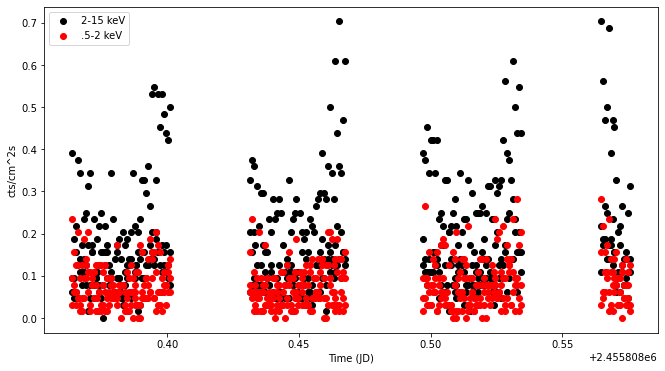

In [25]:
idx=tgtlabels_unique.index('ABELL 426 NNE7')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

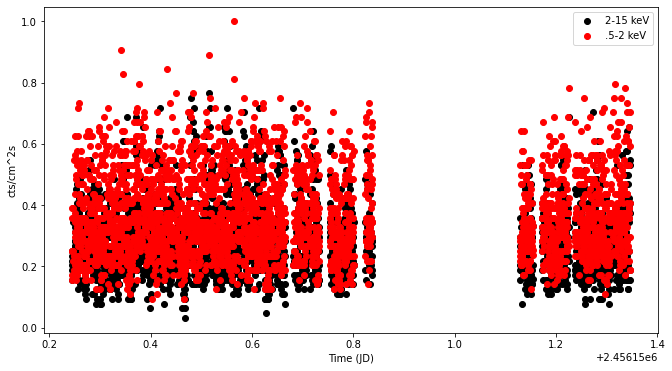

In [26]:
idx=tgtlabels_unique.index('EK TRA')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

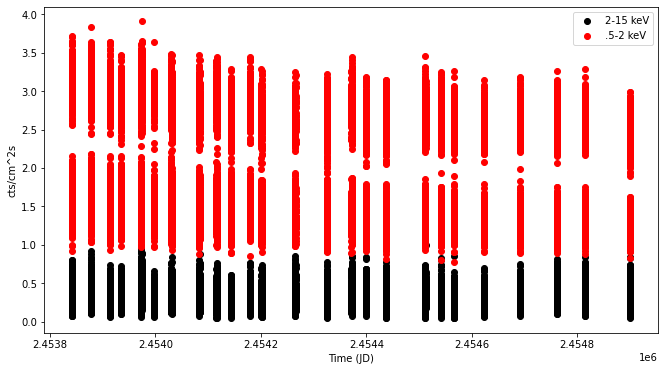

In [27]:
idx=tgtlabels_unique.index('E0102.2-7219')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

Wow, these all demonstrate VERY similar light curves in an extremely stable long-term environment.  Sure enough, the known calibration source E0102.2-7219 is among them!  It may be worth looking at these other sources as possible calibration targets, thanks ML!

Now that we've had some fun with the light curves, let's examine the spectra from Suzaku with yet another HEASARC pre-curated data set.

In [28]:
fp=open(path+'suzaku_specs.pkl','rb');specs=pickle.load(fp);fp.close()
fp=open(path+'suzaku_specs_tgtlabels.pkl','rb');spec_labels=pickle.load(fp);fp.close()
specs=np.array(specs)
spec_labels=np.array(spec_labels)

This is an array of 3040 spectra, each of length 1024. These spectra were extracted from raw observation data and interpolated to energies corresponding to the following array, 'xref', for the purposes of standardization for ML.

In [29]:
xref=np.arange(.5,15.,.01)
xref=xref[:1024]

Let's examine a few spectra.  To do so, define a function for plotting a spectrum, which is usually viewed in a log-log plot.  Then, randomly choose a few spectra.

In [30]:
def spectrum_plot(idx):
    plt.figure(figsize=(11,6))
    plt.plot(xref,specs[idx])
    plt.title(spec_labels[idx])
    plt.xlabel('Energy (keV)');
    plt.ylabel('cts/cm^2s/keV');
    plt.semilogx();
    plt.semilogy();

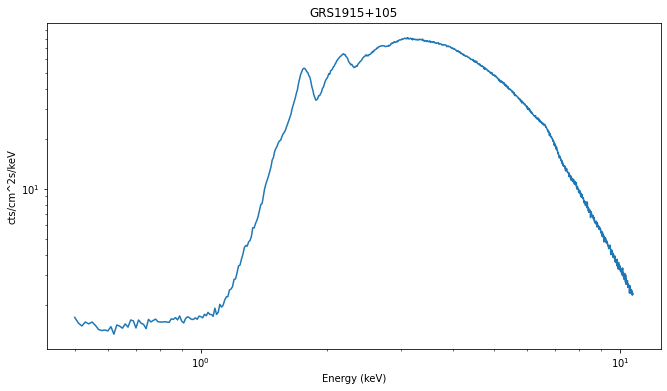

In [31]:
spectrum_plot(93)

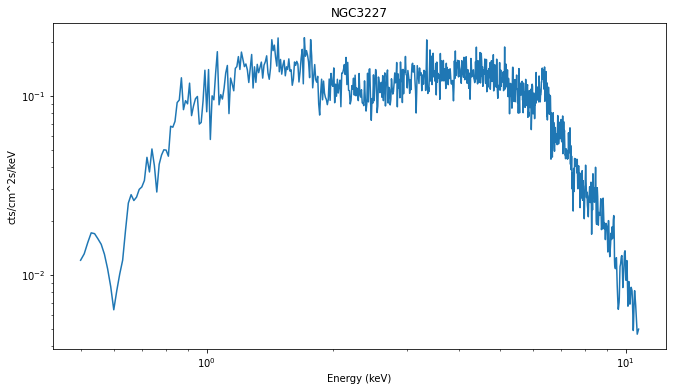

In [32]:
spectrum_plot(1800)

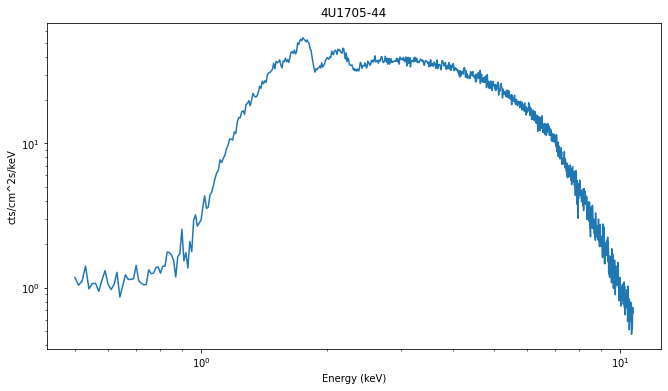

In [33]:
spectrum_plot(455)

Interesting.  The first and third spectra above (GRS 1915+105 and 4U 1705-44) are quite similar.  These are a black hole binary and a neutron star binary, respectively, but both fall into a the category of Low-Mass X-ray Binaries (LMXB).  Can we build a classifier using AI/ML to find other LMXBs in the data set?  Let's find out.

First, find all the spectra for these two sources.

In [34]:
from sklearn.preprocessing import MinMaxScaler
specs_scaled=[]
for i in range(specs.shape[0]):
    s=MinMaxScaler()
    specs_scaled.append(s.fit_transform(specs[i].reshape(-1,1)).T[0])
specs_scaled=np.array(specs_scaled)

Now, create the train and test data sets.

In [35]:
spec_labels=np.array([''.join([i for i in t if i.isalpha() or i.isnumeric()]).lower() for t in spec_labels])
xtrain_pos_idx=(spec_labels=='cygnusx1') | (spec_labels=='4u170544') | (spec_labels=='grs1915105') | (spec_labels=='aqlx1') | (spec_labels=='gx172') | (spec_labels=='serpensx1') | (spec_labels=='gx3492')
xtrain_neg_idx=(spec_labels=='ngc3227') | (spec_labels=='abell426nne7') | (spec_labels=='1e17243045') | (spec_labels=='a1750s') | (spec_labels=='casa') | (spec_labels=='crab') | (spec_labels=='tausco') | (spec_labels=='v773tau') | (spec_labels=='ems1150') | (spec_labels=='v2491cyg') | (spec_labels=='crabnebula')
xtrain_pos=specs[xtrain_pos_idx]
xtrain_neg=specs[xtrain_neg_idx]
xtrain_pos_labels=spec_labels[xtrain_pos_idx]
xtrain_neg_labels=spec_labels[xtrain_neg_idx]
ytrain_pos=np.ones(xtrain_pos.shape[0])
ytrain_neg=np.zeros(xtrain_neg.shape[0])
xtrain=np.vstack((xtrain_pos,xtrain_neg))
xtrain_labels=np.hstack((xtrain_pos_labels,xtrain_neg_labels))
ytrain=np.hstack((ytrain_pos,ytrain_neg))
xval=specs[~(xtrain_pos_idx | xtrain_neg_idx)]
xval_labels=spec_labels[~(xtrain_pos_idx | xtrain_neg_idx)]
xtrain=np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))
xval=np.reshape(xval,(xval.shape[0],xval.shape[1],1))

We will be training this neural network without a test set.  For actual use purposes, this is not practical.  However, we simply want to see if this data contains any predictive power as a quick test.  We will use a 1D Convolutional Neural Network (CNN), which will allow the neural network to identify particular shapes in the spectrum rather than focusing on the values at specific energies.

In [36]:
##### CHANGE ######
dropout_frac=.5
channels_1=16 #integer only
channels_2=32 #integer only
channels_3=64 #integer only
kernel_size=4 #integer only

# PICK ONE
optimizer='rmsprop'
#optimizer='adam'
#optimizer='adadelta'
#optimizer='nadam'
#omtimizer='adagrad'
#optimizer='sgd'

#################

inputlayer=Input(shape=(1024,1))
x=Conv1D(channels_1,kernel_size=kernel_size,strides=1,padding='same')(inputlayer)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=.1)(x)
x=Dropout(dropout_frac)(x)
x=Conv1D(channels_2,kernel_size=kernel_size,strides=1,padding='same')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=.1)(x)
x=Dropout(dropout_frac)(x)
x=Conv1D(channels_3,kernel_size=kernel_size,strides=1,padding='same')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=.1)(x)
x=Flatten()(x)
x=Dropout(dropout_frac)(x)
outputlayer=Dense(1,activation='sigmoid')(x)
model=Model(inputs=[inputlayer],outputs=[outputlayer])
model.compile(loss='binary_crossentropy',optimizer='rmsprop')
modelcheckpoint=ModelCheckpoint(weightpath+'suzaku_spectrum_classifier.weights', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlystopping=EarlyStopping(monitor='loss', min_delta=0., patience=30, verbose=0, mode='auto')
model.fit(xtrain,ytrain,epochs=1000,callbacks=[modelcheckpoint,earlystopping]);
model.load_weights(weightpath+'suzaku_spectrum_classifier.weights')

Epoch 1/1000
4/4 [==============================] - ETA: 0s - loss: 1.2957
Epoch 1: loss improved from inf to 1.29567, saving model to ./model_weights/suzaku_spectrum_classifier.weights
4/4 [==============================] - 1s 66ms/step - loss: 1.2957
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 0.5630
Epoch 2: loss improved from 1.29567 to 0.56300, saving model to ./model_weights/suzaku_spectrum_classifier.weights
4/4 [==============================] - 0s 69ms/step - loss: 0.5630
Epoch 3/1000
4/4 [==============================] - ETA: 0s - loss: 0.8763
Epoch 3: loss did not improve from 0.56300
4/4 [==============================] - 0s 57ms/step - loss: 0.8763
Epoch 4/1000
4/4 [==============================] - ETA: 0s - loss: 0.6448
Epoch 4: loss did not improve from 0.56300
4/4 [==============================] - 0s 56ms/step - loss: 0.6448
Epoch 5/1000
4/4 [==============================] - ETA: 0s - loss: 0.5597
Epoch 5: loss improved from 0.56300 to 0.5597

Now that the neural network has trained, let's predict the validation set and see what happens.  Remember that we are interested in output values near 1, which means the neural net "thinks" that the spectrum is very similar to known X-ray binaries.

92/92 [==============================] - 1s 9ms/step


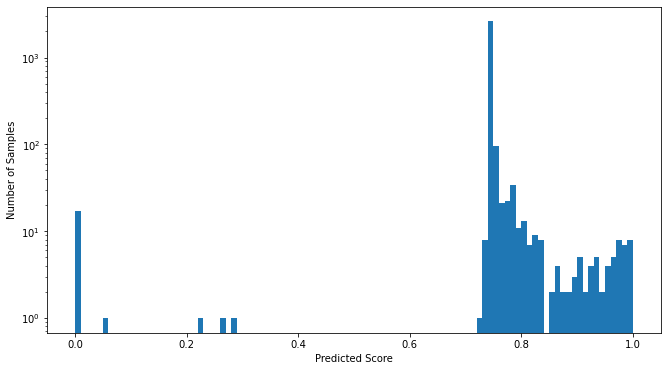

In [37]:
p=model.predict(xval)
plt.figure(figsize=(11,6))
plt.hist(p,bins=100);
plt.xlabel('Predicted Score');
plt.ylabel('Number of Samples');
plt.semilogy();

Most outputs were near 0.5, which means that the neural network has no ability to predict whether or not the spectrum is from an X-ray binary.  This is expected based on the poor training set.  However, there are a few with scores near 1.  Let's find out what they are.

In [38]:
xval_labels[p[:,0]>.9]

array(['cygx1', 'x1630472', 'x1630472', 'x1630472', 'x1630472',
       'x1630472', 'x1630472', 'cygnusx3', '4u182030', 'cygnusx2',
       '4u1636536', '4u1636536', '4u1636536', 'gx3394', 'cygx1', 'cygx1',
       'gx3400', 'cygx1', '4u160852', '4u160852', 'a053526', '4u182030',
       '4u182030', '4u182030', '4u182030', '4u182030', '4u182030',
       '4u182030', 'gx99', 'cygx1', 'gx3041', 'cygx1', 'cygx1',
       '4u173544', '4u173544', 'x1630472', 'x1630472', 'x1630472',
       'xtej1752223', 'gx3041', 'maxij1659152', 'maxij1659152', 'cygx1',
       '4u163047', '4u163047', 'swiftj174510262411', 'groj100857',
       'ks1947300', 'maxij1828249', 'groj174428'], dtype='<U20')

In [39]:
def spectrum_plot_test(idx):
    plt.figure(figsize=(11,6))
    plt.plot(xref,xval[idx])
    plt.title(xval_labels[idx])
    plt.xlabel('Energy (keV)');
    plt.ylabel('cts/cm^2s/keV');
    plt.semilogx();
    plt.semilogy();

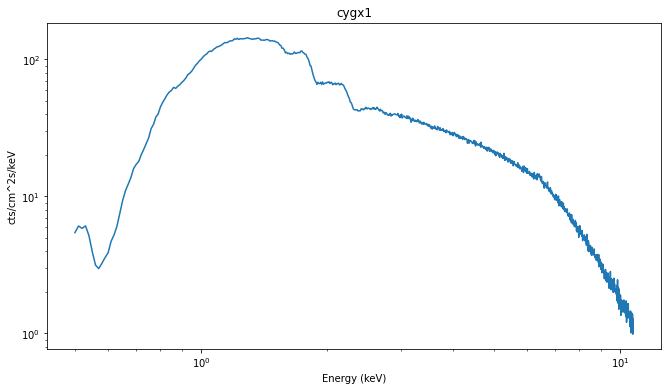

In [40]:
spectrum_plot_test(np.where(p[:,0]>.9)[0][0])

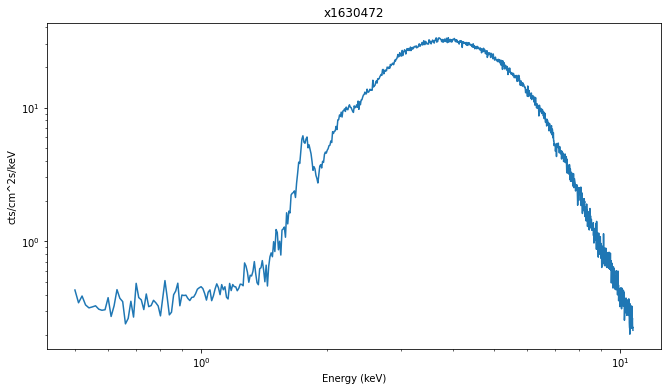

In [41]:
spectrum_plot_test(np.where(p[:,0]>.9)[0][1])

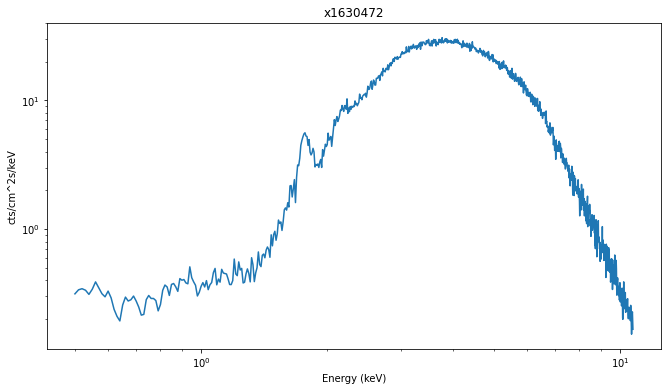

In [42]:
spectrum_plot_test(np.where(p[:,0]>.9)[0][2])

Your outputs will be slightly different based on the training randomization.  Some quick research will likely show that most if not all of these sources are LMXBs!